# SAM

In [ ]:
import cv2
import numpy as np

# Load image
image_bgr = cv2.imread("images/frame_20250429_183115.png")
if image_bgr is None:
    raise RuntimeError("Could not load image.")

image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
image_display = image_bgr.copy()
clicked_points = []

# Mouse callback function
def on_mouse(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN and len(clicked_points) < 2:
        hsv_value = image_hsv[y, x]
        clicked_points.append((x, y, hsv_value))

        # Draw a small cross
        cv2.drawMarker(image_display, (x, y), (0, 0, 255), cv2.MARKER_CROSS, 10, 2)
        cv2.imshow("Click to sample HSV", image_display)

        print(f"Clicked point {len(clicked_points)}: x={x}, y={y}, HSV={hsv_value}")

        if len(clicked_points) == 2:
            print("\nDone! Use these HSV values to tune your threshold.")
            print(f"Background HSV: {clicked_points[0][2]}")
            print(f"Foreground HSV: {clicked_points[1][2]}")
            cv2.waitKey(0)
            cv2.destroyAllWindows()

# Display the image and wait for two clicks
cv2.imshow("Click to sample HSV", image_display)
cv2.setMouseCallback("Click to sample HSV", on_mouse)
print("Click once on the BACKGROUND, then once on the CATHETER TIP.")

input_point = np.array([clicked_points[0][:2], clicked_points[1][:2]])
input_label = np.array([0, 1]) # 0 for background, 1 for foreground
print("Input point:", input_point)

cv2.waitKey(0)
cv2.destroyAllWindows()

# SAM model and image set up

In [46]:
import cv2
import numpy as np
import torch
from segment_anything import sam_model_registry, SamPredictor
from matplotlib import pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

# ──────────────────────────────────────────────────────────────────────────────
# 1. Load SAM ViT-B on CPU
# ──────────────────────────────────────────────────────────────────────────────
checkpoint_path = "/home/arclab/repos/segment-anything/checkpoints/sam_vit_b_01ec64.pth"
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to("cuda")
predictor = SamPredictor(sam)

# ──────────────────────────────────────────────────────────────────────────────
# 2. Load image and create coarse foreground mask (non-green areas)
# ──────────────────────────────────────────────────────────────────────────────
img_bgr = cv2.imread("images/frame_20250429_183115.png")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
print("Original image shape:", img_bgr.shape)


lower_green = np.array([35, 30, 100])
upper_green = np.array([85, 255, 255])
green_mask = cv2.inRange(img_hsv, lower_green, upper_green)
foreground_mask = cv2.bitwise_not(green_mask)
binary_mask = np.where(foreground_mask > 0, 1, 0).astype(np.uint8)


if img_bgr is None:
    raise RuntimeError("Could not load image.")

predictor.set_image(img_rgb)


/home/arclab/repos/segment-anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Original image shape: (480, 640, 3)


# Automated point and box prompting

Centroid coordinates: 239 298


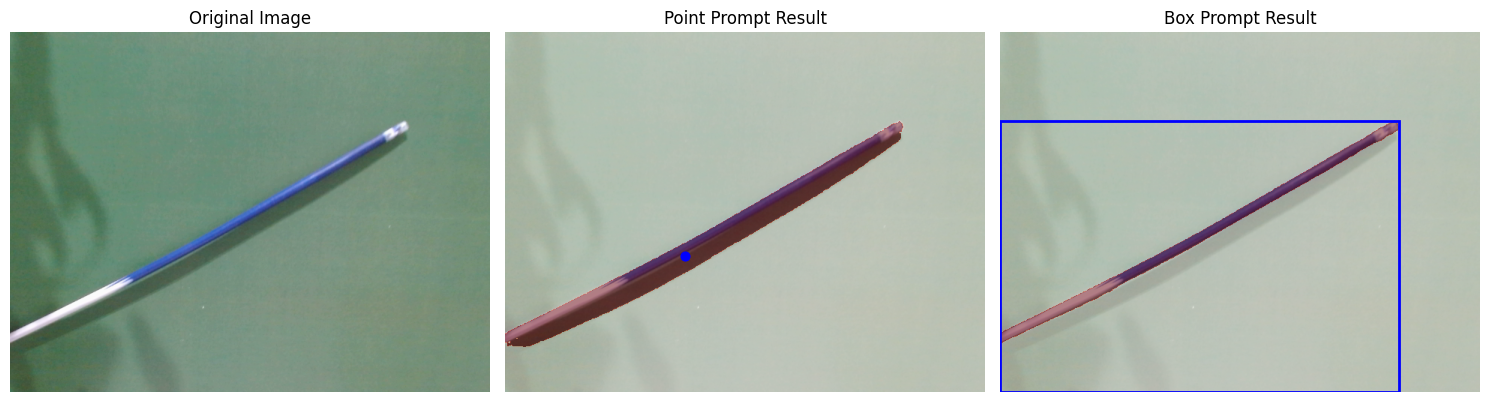

In [49]:
import cv2
import numpy as np
import torch
from segment_anything import SamPredictor, sam_model_registry
import matplotlib.pyplot as plt


# ===============================================
# ============ APPROACH 1: POINT PROMPT =========
# ===============================================
# Get the centroid of the binary mask
M = cv2.moments(binary_mask)
if M["m00"] != 0:
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    point_coords = np.array([[cx, cy]])
else:
    raise ValueError("No foreground pixels found in binary mask")

print("Centroid coordinates:", cx, cy)


point_labels = np.array([1])  # 1 = foreground

masks_point, scores_point, _ = predictor.predict(
    point_coords=point_coords,
    point_labels=point_labels,
    multimask_output=False,
)

# ===============================================
# ============ APPROACH 2: BOX PROMPT ===========
# ===============================================
x, y, w, h = cv2.boundingRect(binary_mask)
box = np.array([[x, y, x + w, y + h]])

masks_box, scores_box, _ = predictor.predict(
    box=box,
    multimask_output=False
)

# ---- Visualize Results ----
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(image_rgb)
axs[0].set_title("Original Image")

axs[1].imshow(image_rgb)
axs[1].imshow(masks_point[0], alpha=0.5, cmap='Reds')
axs[1].scatter(cx, cy, c='blue', s=40)
axs[1].set_title("Point Prompt Result")

axs[2].imshow(image_rgb)
axs[2].imshow(masks_box[0], alpha=0.5, cmap='Reds')
axs[2].add_patch(plt.Rectangle((x, y), w, h, edgecolor='blue', facecolor='none', lw=2))
axs[2].set_title("Box Prompt Result")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:

# Show original image
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
show_points(input_point, input_label, plt.gca())
plt.title("Original Image")
plt.axis('off')
plt.show()


# Define green background HSV range
lower_green = np.array([35, 30, 100])
upper_green = np.array([85, 255, 255])
green_mask = cv2.inRange(img_hsv, lower_green, upper_green)
print("max val: ", np.max(green_mask))
print("min val: ", np.min(green_mask))

# Invert: 1 for non-green (catheter), 0 for background
foreground_mask = cv2.bitwise_not(green_mask)
print("max val: ", np.max(foreground_mask))

# Optionally clean up mask
kernel = np.ones((5,5), np.uint8)
foreground_mask = cv2.morphologyEx(foreground_mask, cv2.MORPH_OPEN, kernel)
print("max val: ", np.max(foreground_mask))
# Convert to binary mask
binary_mask = np.where(foreground_mask > 0, 1, 0).astype(np.uint8)

print("min val: ", np.min(binary_mask))
print("max val: ", np.max(binary_mask))
print("binary mask shape: ", binary_mask.shape)
# Visualize foreground mask
plt.figure(figsize=(8, 8))
plt.imshow(binary_mask, cmap='gray')
plt.title("Foreground Mask (Non-Green Areas)")
plt.axis('off')
plt.show()


In [ ]:


# # Resize the coarse mask to SAM's expected prompt input resolution
# # For ViT-B: patch size = 16 → input image (1024) / 16 = 64 → 1/4 = 16x16
# prompt_H, prompt_W = 256, 256

# coarse_mask = cv2.resize(
#     coarse_mask.astype(np.float32),
#     (prompt_W, prompt_H),
#     interpolation=cv2.INTER_NEAREST
# )

# print("Coarse mask shape:", coarse_mask.shape)
# plt.figure(figsize=(8, 8))
# plt.imshow(coarse_mask)
# plt.title("Coarse Mask (Non-Green Areas)")
# plt.axis('off')
# plt.show()

# # ──────────────────────────────────────────────────────────────────────────────
# # 3. Feed image to SAM
# # ──────────────────────────────────────────────────────────────────────────────
# image_embedding = predictor.get_image_embedding().cpu().numpy()

# print("Image embedding shape:", image_embedding.shape)
# print("Sample values:", image_embedding[0, :, :5, :5])  # Print part of it for inspection


# # # Add channel dimension → (1, 16, 16)
# # mask_input = mask_resized[np.newaxis, :, :]
# # print(f"Mask input shape: {mask_input.shape}")

# # ──────────────────────────────────────────────────────────────────────────────
# # 4. Run SAM with dense prompt only
# # ──────────────────────────────────────────────────────────────────────────────
# with torch.inference_mode():
#     masks, scores, logits = predictor.predict(
#         point_coords=input_point,
#         point_labels=input_label,
#         # box=None,
#         # mask_input=mask_input,
#         multimask_output=True
#     )

# for i, (mask, score) in enumerate(zip(masks, scores)):
#     plt.figure(figsize=(10,10))
#     plt.imshow(img_rgb)
#     show_mask(mask, plt.gca())
#     show_points(input_point, input_label, plt.gca())
#     plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
#     plt.axis('off')
#     plt.show()  

# best_mask = logits[np.argmax(scores), :, :]
# print(f"Best mask logit shape: {best_mask.shape}")

# # Run prediction again with best_mask as prompt
# refined_mask, scores, logits = predictor.predict(
#     point_coords=None,
#     point_labels=None,
#     box=None,
#     multimask_output=False,
#     mask_input=best_mask[None, :, :]
# )

# Run prediction with coarse mask as prompt
binary_mask = cv2.resize(binary_mask, (256, 256), interpolation=cv2.INTER_NEAREST)
logit_mask = np.where(binary_mask > 0, 10.0, -10.0).astype(np.float32)
print(np.max(logit_mask))
output_mask_coarse, scores, logits = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=None,
    multimask_output=False,
    mask_input=logit_mask[None, :, :]
)

print("Scores:", scores)

plt.figure(figsize=(8, 8))
plt.imshow(output_mask_coarse[0, :, :], cmap='gray')
plt.title("Coarse Mask Output")
plt.axis('off')
plt.show()

# # # Refined mask (shape: 1024x1024)
# # output_mask = masks[0,:,:].astype(np.uint8)
# # print(f"Output masks shape: {output_mask.shape}")

# # # ──────────────────────────────────────────────────────────────────────────────
# # # 5. Upsample refined mask to original image size and overlay
# # # ──────────────────────────────────────────────────────────────────────────────
# # # H_orig, W_orig = img_rgb.shape[:2]
# # # mask_fullres = cv2.resize(
# # #     refined_mask,
# # #     (W_orig, H_orig),
# # #     interpolation=cv2.INTER_NEAREST
# # # )

# # # ──────────────────────────────────────────────────────────────────────────────
# # # 6. Visualize overlay
# # # ──────────────────────────────────────────────────────────────────────────────
# plt.figure(figsize=(8, 8))
# # plt.imshow(img_rgb)
# plt.imshow(refined_mask[0, :, :], cmap='gray')
# plt.title("SAM Output Mask")
# plt.axis('off')
# plt.show()


# Automatic mask generation

In [ ]:
from segment_anything import SamAutomaticMaskGenerator

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.array([1.0, 0.0, 0.0, 0.35])  # Red color with 35% opacity
        img[m] = color_mask
    ax.imshow(img)


# Use SAM to automatically generate masks for image
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(img_rgb)

print("Number of masks: ", len(masks))
print(masks[0].keys())

plt.figure(figsize=(20,20))
plt.imshow(img_rgb)
show_anns(masks)
plt.axis('off')
plt.show() 

# Visualize the mask with the best predicted_iou
best_mask_ann = max(masks, key=lambda x: x['predicted_iou'])
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
show_anns([best_mask_ann])
plt.axis('off')
plt.title("Best Mask with Highest Predicted IoU")
plt.show()

for idx, mask_ann in enumerate(masks):
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    show_anns([mask_ann])
    plt.axis('off')
    plt.title(f"Mask {idx + 1} - Predicted IoU: {mask_ann['predicted_iou']:.3f}, Stability Score: {mask_ann['stability_score']:.3f}")
    plt.show()

# Calibration

In [ ]:
import cv2
import numpy as np
import glob
import os

def calibrate_intrinsics(image_glob, pattern_size=(9,6), square_size=0.025):
    """
    Calibrate a single camera's intrinsics using checkerboard images.
    
    Args:
        image_glob (str): Glob pattern for calibration images.
        pattern_size (tuple): Number of inner corners per checkerboard row, col.
        square_size (float): Size of a checkerboard square in meters.
        
    Returns:
        ret (float): RMS re-projection error.
        K (ndarray): Camera matrix (3x3).
        dist (ndarray): Distortion coefficients.
        rvecs, tvecs: Extrinsic vectors for each image.
    """
    # Prepare object points (0,0,0), ..., scaled by square_size
    objp = np.zeros((pattern_size[0]*pattern_size[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1,2)
    objp *= square_size

    objpoints, imgpoints = [], []
    images = glob.glob(image_glob)
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)
        if not ret:
            continue
        corners2 = cv2.cornerSubPix(
            gray, corners, (11,11), (-1,-1),
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        )
        objpoints.append(objp)
        imgpoints.append(corners2)

    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None
    )
    print(f"Intrinsics RMS error: {ret:.4f}")
    return ret, K, dist, rvecs, tvecs

def stereo_calibrate(
    glob1, glob2, pattern_size, square_size,
    K1, d1, K2, d2,
    flags=cv2.CALIB_FIX_INTRINSIC
):
    """
    Stereo calibrate two cameras that have already been intrinsically calibrated.
    
    Args:
        glob1, glob2: Glob patterns for the two cameras' images.
        pattern_size, square_size: Checkerboard parameters.
        K1, d1, K2, d2: Intrinsics and distortions for camera 1 and 2.
        flags: calibration flags.
        
    Returns:
        R, T, E, F: Rotation, translation, essential and fundamental matrices.
    """
    objp = np.zeros((pattern_size[0]*pattern_size[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1,2)
    objp *= square_size

    objpoints, imgpoints1, imgpoints2 = [], [], []
    imgs1 = sorted(glob.glob(glob1))
    imgs2 = sorted(glob.glob(glob2))
    for f1, f2 in zip(imgs1, imgs2):
        im1 = cv2.imread(f1); gray1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
        im2 = cv2.imread(f2); gray2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
        r1, c1 = cv2.findChessboardCorners(gray1, pattern_size, None)
        r2, c2 = cv2.findChessboardCorners(gray2, pattern_size, None)
        if not (r1 and r2):
            continue
        c1 = cv2.cornerSubPix(
            gray1, c1, (11,11), (-1,-1),
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        )
        c2 = cv2.cornerSubPix(
            gray2, c2, (11,11), (-1,-1),
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        )
        objpoints.append(objp)
        imgpoints1.append(c1)
        imgpoints2.append(c2)

    ret, _, _, _, _, R, T, E, F = cv2.stereoCalibrate(
        objpoints, imgpoints1, imgpoints2,
        K1, d1, K2, d2,
        gray1.shape[::-1],
        criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5),
        flags=flags
    )
    print(f"Stereo RMS error: {ret:.4f}")
    return R, T, E, F

def calibrate_camera_to_world(
    image_glob, world_objpoints=None,
    pattern_size=(9,6), square_size=0.025,
    K=None, dist=None
):
    """
    Solve PnP to get camera-to-world extrinsics using a known world marker.
    
    Args:
        image_glob: Glob for images where the world marker is visible.
        world_objpoints: (N×3) array of 3D points in world coords.
        pattern_size, square_size: if using a checkerboard as your world frame.
        K, dist: intrinsic calibration for this camera.
        
    Returns:
        rvec, tvec: rotation and translation from world to camera.
    """
    if world_objpoints is None:
        wp = np.zeros((pattern_size[0]*pattern_size[1],3), np.float32)
        wp[:,:2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1,2)
        wp *= square_size
        world_objpoints = wp

    for fname in glob.glob(image_glob):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)
        if not ret:
            continue
        corners2 = cv2.cornerSubPix(
            gray, corners, (11,11), (-1,-1),
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        )
        ret, rvec, tvec = cv2.solvePnP(world_objpoints, corners2, K, dist)
        if ret:
            proj, _ = cv2.projectPoints(world_objpoints, rvec, tvec, K, dist)
            err = np.linalg.norm(corners2.reshape(-1,2) - proj.reshape(-1,2)) / len(proj)
            print(f"SolvePnP reprojection error: {err*1e3:.2f} mm")
            return rvec, tvec
    raise RuntimeError("Marker not detected in any image")

if __name__ == "__main__":
    # 1) Intrinsics
    _, K1, d1, _, _ = calibrate_intrinsics("calib_images/cam1/*.png")
    _, K2, d2, _, _ = calibrate_intrinsics("calib_images/cam2/*.png")
    
    # 2) Stereo extrinsics
    R, T, E, F = stereo_calibrate(
        "calib_images/cam1/*.png", "calib_images/cam2/*.png",
        pattern_size=(9,6), square_size=0.025,
        K1=K1, d1=d1, K2=K2, d2=d2
    )
    
    # 3) Camera-to-world
    rvec1, tvec1 = calibrate_camera_to_world(
        "marker_images/cam1/*.png", None,
        pattern_size=(9,6), square_size=0.025,
        K=K1, dist=d1
    )
    rvec2, tvec2 = calibrate_camera_to_world(
        "marker_images/cam2/*.png", None,
        pattern_size=(9,6), square_size=0.025,
        K=K2, dist=d2
    )
    
    print("Calibration complete.")


# Pose Estimation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def back_project(coord, camera_number):
    """
    Back-project a 3D point to 2D pixel coordinates in the image plane.
    
    Args:
        coord: 3D point in world coordinates.
        camera_number: 0 for left camera, 1 for right camera.
        
    Returns:
        pixel_coord: 2D pixel coordinates in the image plane.
    """
    # Camera intrinsics and extrinsics (example values)
    K = np.array([[1000, 0, 320],
                  [0, 1000, 240],
                  [0, 0, 1]])
    R = np.eye(3) if camera_number == 0 else np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    T = np.array([0.5, 0, 0]) if camera_number == 1 else np.array([0, 0, 0])
    
    # Project the point
    coord_homogeneous = np.append(coord, 1) # Convert to homogeneous coordinates
    pixel_coord_homogeneous = K @ (R @ coord_homogeneous + T)
    pixel_coord = pixel_coord_homogeneous[:2] / pixel_coord_homogeneous[2]
    
    return pixel_coord

# 1) Create lookup table for voxel grid
Nx, Ny, Nz = 20, 20, 20
origin = np.array([0, 0, 0])
voxel_size = np.array([0.01, 0.01, 0.01])
lookup_table = np.zeros((Nx, Ny, Nz, 2, 2), dtype=np.float32)
for x in range(Nx):
    for y in range(Ny):
        for z in range(Nz):
            coord = origin + np.array([x, y, z]) * voxel_size
            for camera_number in range(2):
                pixel_coord = back_project(coord, camera_number)
                lookup_table[x, y, z, camera_number] = np.reshape(pixel_coord, 2)

In [ ]:
# 2) Obtain masks for left and right cameras
# TODO: Replace with actual image loading and processing
mask_0 = np.zeros((480, 640), dtype=np.uint8)
mask_1 = np.zeros((480, 640), dtype=np.uint8)

# 3) Voxel carving: keep (x,y,z) if both silhouettes agree
volume = np.zeros((Nx, Ny, Nz), dtype=np.uint8)
for x in range(Nx):
    for y in range(Ny):
        for z in range(Nz):
            pixel_coord_0 = lookup_table[x, y, z, 0]
            pixel_coord_1 = lookup_table[x, y, z, 1]
            if mask_0[pixel_coord_0[0], pixel_coord_0[1]] and \
               mask_1[pixel_coord_1[0], pixel_coord_1[1]]:
                volume[x, y, z] = 1
                
points = np.argwhere(volume == 1)  # Get indices of carved voxels
                

# 4) Compute a simple centerline: for each z-slice, average x & y
centerline = []
for zk in z:
    slice_pts = points[np.isclose(points[:, 2], zk)]
    if len(slice_pts) > 0:
        cx, cy = slice_pts[:,0].mean(), slice_pts[:,1].mean()
        centerline.append([cx, cy, zk])
centerline = np.array(centerline)

# 5) Estimate tangent at the tip (last two points)
v = centerline[-1] - centerline[-2]
theta = np.arccos(v[2] / np.linalg.norm(v))  # bending magnitude
phi   = np.arctan2(v[1], v[0])              # bending plane

print("Estimated bending angle θ (rad):", theta)
print("Estimated bending plane φ (rad):", phi)

# 6) Plot a 2D x–z view of the carved voxels and the centerline
fig, ax = plt.subplots()
ax.scatter(points[:,0], points[:,2], marker='.', label='voxels')
ax.plot(centerline[:,0], centerline[:,2], label='centerline')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.legend()
plt.show()


# Create Charuco board

In [ ]:
import cv2, cv2.aruco as aruco
import numpy as np

# print([n for n in dir(cv2.aruco) if n.startswith("DICT")])

# 1. Choose your ArUco dictionary
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)

# 2. Create a ChArUco board: 7×5 chessboard squares, each square = 0.04 m, marker length = 0.03 m
charuco_board = aruco.CharucoBoard(
    (11, 8),
    squareLength=0.015, markerLength=0.011,
    dictionary=aruco_dict
)

# 3. Draw & save an image of the board at 200 DPI
img = charuco_board.draw((2000, 1500))
cv2.imwrite("charuco_board.png", img)

# Pixel Color Classifier

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

class PixelColorClassifier:
    def __init__(self, model_type='logistic', color_space='HSV'):
        """
        Parameters:
            model_type: 'logistic' or 'naive_bayes'
            color_space: 'HSV', 'RGB', or 'BGR'
        """
        if model_type == 'logistic':
            self.model = LogisticRegression(max_iter=200)
        elif model_type == 'naive_bayes':
            self.model = GaussianNB()
        else:
            raise ValueError("Unsupported model_type. Choose 'logistic' or 'naive_bayes'.")
        
        self.model_type = model_type
        self.color_space = color_space
        self.trained = False

    def _convert_color(self, image_bgr):
        import cv2
        if self.color_space == 'HSV':
            return cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
        elif self.color_space == 'RGB':
            return cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        elif self.color_space == 'BGR':
            return image_bgr
        else:
            raise ValueError("Unsupported color space")

    def fit(self, image_bgr, fg_mask, bg_mask, max_samples=1000):
        """
        Train the model using foreground and background binary masks.

        Parameters:
            image_bgr: Input image (BGR format)
            fg_mask: Binary mask where foreground pixels are 255
            bg_mask: Binary mask where background pixels are 255
        """
        img_color = self._convert_color(image_bgr)
        H, W, _ = img_color.shape
        flat_img = img_color.reshape(-1, 3)

        fg_indices = np.where(fg_mask.flatten() > 0)[0]
        bg_indices = np.where(bg_mask.flatten() > 0)[0]

        n_fg = min(max_samples, len(fg_indices))
        n_bg = min(max_samples, len(bg_indices))

        fg_sample = np.random.choice(fg_indices, n_fg, replace=False)
        bg_sample = np.random.choice(bg_indices, n_bg, replace=False)

        X = np.vstack((flat_img[fg_sample], flat_img[bg_sample]))
        y = np.hstack((np.ones(n_fg), np.zeros(n_bg)))

        self.model.fit(X, y)
        self.trained = True

    def predict_proba(self, image_bgr):
        """
        Predict foreground probability for each pixel.

        Parameters:
            image_bgr: Input image (BGR format)

        Returns:
            prob_map: 2D numpy array of foreground probabilities
        """
        if not self.trained:
            raise RuntimeError("PixelColorClassifier must be trained with `fit()` before prediction.")

        img_color = self._convert_color(image_bgr)
        H, W, _ = img_color.shape
        flat_img = img_color.reshape(-1, 3)

        proba = self.model.predict_proba(flat_img)[:, 1]
        return proba.reshape(H, W)
